# REMOVE SPECTOGRAMS FROM .WAV

In [18]:
import os
import shutil

def remove_spectrograms():
    processed_path = './music_data/musdb18hq_processed'

    if os.path.exists(processed_path):
        print(f'Removing path {processed_path} from OS and all of its contents')
        shutil.rmtree(processed_path)
        print(f'Folder removed successfully.')
    else:
        print(f'No such path exists, path: {processed_path}')

remove_spectrograms()

Removing path ./music_data/musdb18hq_processed from OS and all of its contents
Folder removed successfully.


# CREATE SPECTROGRAMS FROM .WAV

In [24]:
import os
import shutil
import torch
import torchaudio

def create_spectrogram(wav_path):
    waveform, sample_rate = torchaudio.load(wav_path)
    #spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)
    spectrogram = torchaudio.transforms.Spectrogram(n_fft = 1600)(waveform)
    return spectrogram

def stereo_to_mono(stereo_spectrogram):
    left_channel = stereo_spectrogram[0, :, :]
    right_channel = stereo_spectrogram[1, :, :]
    
    # Calculate RMS energy for each channel
    left_rms = torch.sqrt(torch.mean(left_channel**2, dim=0))
    right_rms = torch.sqrt(torch.mean(right_channel**2, dim=0))
    
    # Mix channels using RMS values
    mono_spectrogram = 0.5 * (left_channel / left_rms + right_channel / right_rms)
    
    return mono_spectrogram

def create_spectograms():
    processed_path = './music_data/musdb18hq_processed'

    if os.path.exists(processed_path):
        print(f'Path {processed_path} already exists. Remove before creating new spectograms')
    else:

        # Create the folder to gather the processed wav files.
        print(f'Creating path {processed_path} in OS')
        os.makedirs(processed_path)
        print(f'Creating path {processed_path}/test in OS')
        os.makedirs(processed_path+'/test')
        print(f'Creating path {processed_path}/train in OS')
        os.makedirs(processed_path+'/train')
        print(f'Creating path {processed_path}/test_spectrograms in OS')
        os.makedirs(processed_path+'/test_spectrograms')
        print(f'Creating path {processed_path}/train_spectrograms in OS')
        os.makedirs(processed_path+'/train_spectrograms')

        # Source folder path
        source_folder = './music_data/musdb18hq/test'

        # Destination folder path
        destination_folder = './music_data/musdb18hq_processed/test'

        # Iterate through directories in the source folder
        for idx, dirname in enumerate(os.listdir(source_folder)):
            # Get the full path of the current directory
            source_dir_path = os.path.join(source_folder, dirname)
            
            # Check if it's a directory
            if os.path.isdir(source_dir_path):
                # Generate new directory name with leading zeros
                new_dirname = f'{str(idx+1).zfill(4)}'
                
                # Destination directory path
                destination_dir_path = os.path.join(destination_folder, new_dirname)
                
                # Copy the directory to the destination folder and rename it
                shutil.copytree(source_dir_path, destination_dir_path)
                
                print(f'Copied {dirname} to {new_dirname}')
                
                # Iterate through files in the current directory
                for filename in os.listdir(destination_dir_path):
                    # Full path of the file
                    file_path = os.path.join(destination_dir_path, filename)
                    
                    # Check if the file is not mixture.wav or vocals.wav
                    if filename not in ['mixture.wav', 'vocals.wav']:
                        # Remove the file
                        os.remove(file_path)
                        print(f'Removed {filename} from {new_dirname}')
                    else:
                        print(f'Skipped {dirname} (it is not a directory)')

        # Iterate through the numbered folders
        for idx, dirname in enumerate(os.listdir(destination_folder)):
            # Get the full path of the current directory
            folder_path = os.path.join(destination_folder, dirname)
            
            # Check if it's a directory
            if os.path.isdir(folder_path):
                # File paths for mixture.wav and vocals.wav
                mixture_path = os.path.join(folder_path, 'mixture.wav')
                vocals_path = os.path.join(folder_path, 'vocals.wav')
                
                # Create spectrogram for mixture.wav
                mixture_spectrogram = stereo_to_mono(create_spectrogram(mixture_path))
                mixture_spectrogram = torch.nan_to_num(mixture_spectrogram)
                
                # Create spectrogram for vocals.wav
                vocals_spectrogram = stereo_to_mono(create_spectrogram(vocals_path))
                vocals_spectrogram = torch.nan_to_num(vocals_spectrogram)

                total_spectrogram = torch.stack((mixture_spectrogram, vocals_spectrogram))
                
                # Saving them as tensors:
                torch.save(total_spectrogram, f'./music_data/musdb18hq_processed/test_spectrograms/{dirname}.pt')
         
                print(f'Spectrograms created for {dirname}')
            print('Audio processing complete!')


create_spectograms()

Path ./music_data/musdb18hq_processed already exists. Remove before creating new spectograms


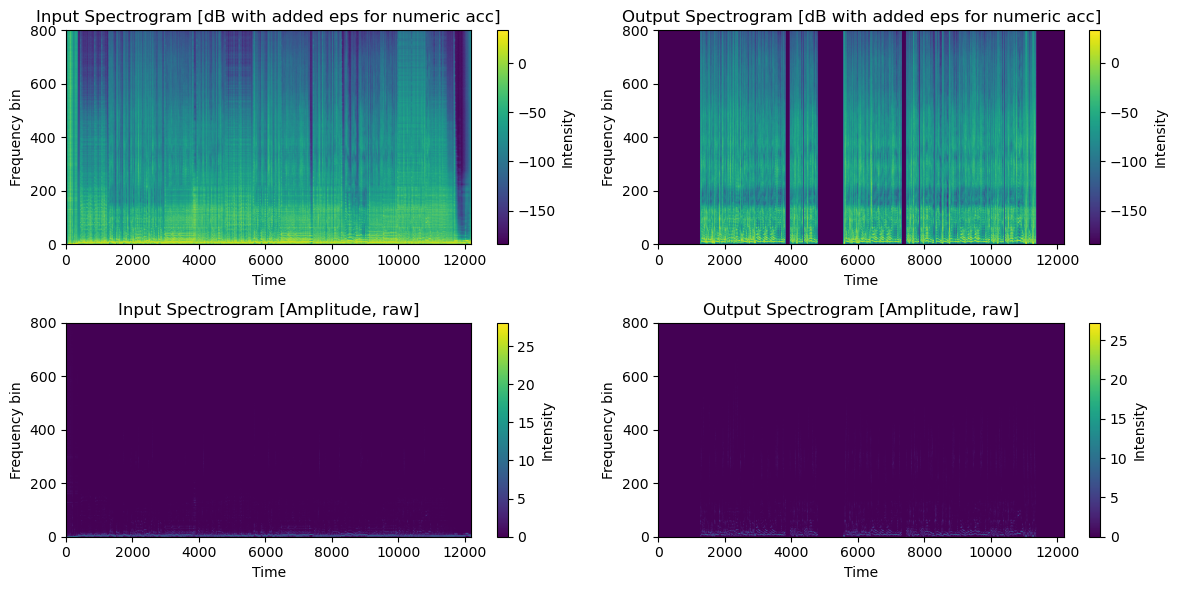

In [27]:
# Test to load spectrogram from .pt file
import matplotlib.pyplot as plt
import numpy as np

my_spectrogram = torch.load('./music_data/musdb18hq_processed/test_spectrograms/0003.pt')
eps = 0.00000001

input_spectrogram = my_spectrogram[0, :, :]
output_spectrogram = my_spectrogram[1, :, :]

# Create subplots with separate windows for input and output
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot input spectrogram in the first subplot
im1 = axs[0][0].imshow(10 * np.log(input_spectrogram.numpy() + eps), aspect='auto', cmap='viridis', origin='lower')
axs[0][0].set_xlabel('Time')
axs[0][0].set_ylabel('Frequency bin')
axs[0][0].set_title('Input Spectrogram [dB with added eps for numeric acc]')
fig.colorbar(im1, ax=axs[0][0], label='Intensity')  # Add colorbar to the first subplot

# Plot output spectrogram in the second subplot
im2 = axs[0][1].imshow(10 * np.log(output_spectrogram.numpy() + eps), aspect='auto', cmap='viridis', origin='lower')
axs[0][1].set_xlabel('Time')
axs[0][1].set_ylabel('Frequency bin')
axs[0][1].set_title('Output Spectrogram [dB with added eps for numeric acc]')
fig.colorbar(im2, ax=axs[0][1], label='Intensity')  # Add colorbar to the second subplot1

[0]# Plot input spectrogram in the first subplot
im1 = axs[1][0].imshow(input_spectrogram.numpy(), aspect='auto', cmap='viridis', origin='lower')
axs[1][0].set_xlabel('Time')
axs[1][0].set_ylabel('Frequency bin')
axs[1][0].set_title('Input Spectrogram [Amplitude, raw]')
fig.colorbar(im1, ax=axs[1][0], label='Intensity')  # Add colorbar to the first subplot

# Plot output spectrogram in the second subplot
im2 = axs[1][1].imshow(output_spectrogram.numpy(), aspect='auto', cmap='viridis', origin='lower')
axs[1][1].set_xlabel('Time')
axs[1][1].set_ylabel('Frequency bin')
axs[1][1].set_title('Output Spectrogram [Amplitude, raw]')
fig.colorbar(im2, ax=axs[1][1], label='Intensity')  # Add colorbar to the second subplot

# Display the subplots
plt.tight_layout()
plt.show()

In [21]:
output_spectrogram.shape

torch.Size([801, 12197])